In [1]:
"""
This file makes calls to functions in the michael_morris_github_code folder.
"""

import sys
sys.path.append("./../common/")
from utils import *
sys.path.append("./../michael_morris_github_code/")
from NNs import *
from DataConstructor import *

figures_dir = "../../dump/"
data_type = 'ili'
filename = 'ili'


16


In [2]:
# optimised hyperparameters
optimised =  {"edl_coeff": 0.00001, "epochs": 979.2437963890364, "lr_power": -3.69, "rnn_units": 15.880451789491315}

irnn_type = FI_ERNN
batch_size=32

if irnn_type.loss == "EDL":
    optimised["kl_power"] = None
    optimised["op_scale"] = None
    optimised["prior_scale"] = None
    optimised["q_scale"] = None
else:
    optimised['edl_coeff'] = None

gammas = [7,14,21,28]
test_seasons = [2015,2016,2017,2018]
models = {}

for gamma in gammas:
    _data = DataConstructor(gamma=gamma)
    x_train, y_train, x_test, y_test = _data(data_type, filename=filename)
    irnns = FI_NNs(rnn_units=optimised['rnn_units'], kl_power=optimised['kl_power'], op_scale=optimised['op_scale'], prior_scale=optimised['prior_scale'], q_scale=optimised['q_scale'], gamma=gamma, lr_power=optimised['lr_power'], n_batches=int(len(y_train)/batch_size), irnn_type=irnn_type, edl_coeff=optimised['edl_coeff'])
    history = irnns.train(x_train, y_train, epochs=int(optimised['epochs']), verbose=False)
    print(history)

    models[str(gamma)] = irnns

[-3.5126945972442627, -3.817605972290039, -3.7064292430877686, -3.7065887451171875, -3.614588737487793, -3.3660895824432373, -3.7631120681762695, -3.852830648422241, -3.644037961959839, -3.6413674354553223]
[-2.675652503967285, -2.7215113639831543, -2.6145505905151367, -2.754103660583496, -2.823335886001587, -2.6064252853393555, -2.829070806503296, -2.8415112495422363, -2.9607388973236084, -2.57283091545105]
[-2.2985310554504395, -2.52333664894104, -2.2882118225097656, -2.547466516494751, -2.4288244247436523, -2.4741251468658447, -2.534849166870117, -2.448744773864746, -2.406911611557007, -2.488715410232544]
[-2.229153871536255, -2.2520511150360107, -2.2343034744262695, -2.25848126411438, -2.22428560256958, -2.301647424697876, -2.230724573135376, -2.31036639213562, -2.3040771484375, -2.2150235176086426]


7
7 2015
LEN 10
7 2016
LEN 10
7 2017
LEN 10
7 2018
LEN 10
14
14 2015
LEN 10
14 2016
LEN 10
14 2017
LEN 10
14 2018
LEN 10
21
21 2015
LEN 10
21 2016
LEN 10
21 2017
LEN 10
21 2018
LEN 10
28
28 2015
LEN 10
28 2016
LEN 10
28 2017
LEN 10
28 2018
LEN 10


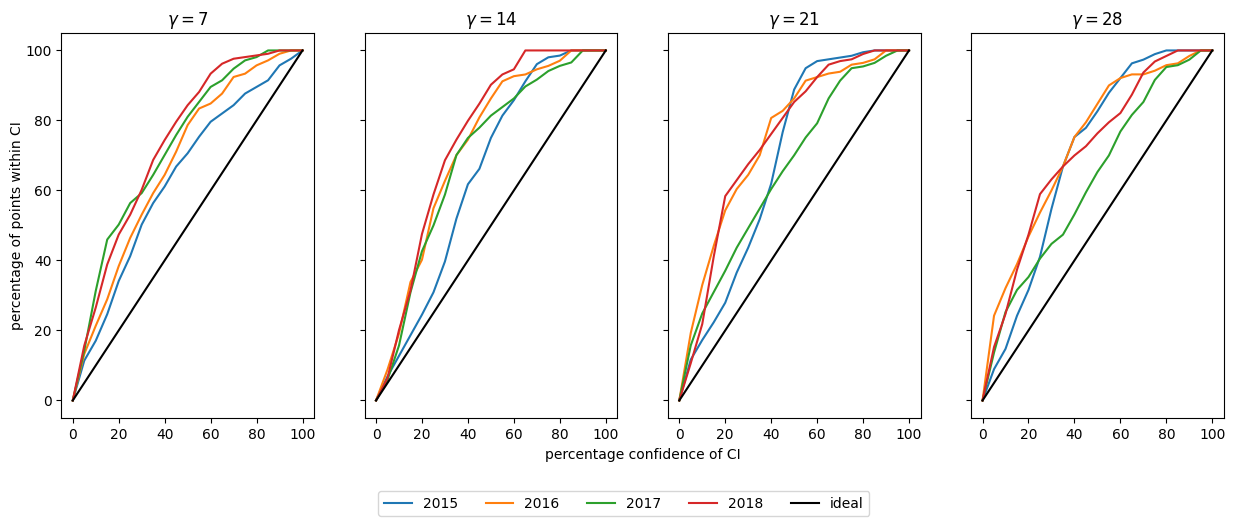

In [3]:
def gamma_data(array, gamma):
    if type(array) != type(np.array([])):
        array = array._numpy()
    return array.flatten()[:len(array)-gamma]

fig, axs = plt.subplots(1, len(models), figsize=(15, 5), sharey=True)
idx = 0

calibrations = {}
predictions = {}
Y_HAT, SD_HAT, MODEL_UNC, DATA_UNC = 0, 1, 2, 3
for gamma, model in models.items():
    calibrations[gamma] = {}
    predictions[gamma] = {}

confidences = get_confidence_axis()
for gamma, model in models.items():
    print(gamma)
    gamma_str = gamma
    gamma = int(gamma)

    for season in test_seasons:
        print(gamma, season)
        season_str = str(season)
        _data = DataConstructor(test_season=season, gamma=gamma)
        _, _, x_test, y_test = _data(data_type, filename=filename)
        predictions[gamma_str][season_str] = model.get_predictions(x_test, stable=True)
        in_range = unc_calibration(gamma_data(y_test[:,-1:,:], gamma), gamma_data(predictions[gamma_str][season_str][Y_HAT][:,-1:,:], gamma), gamma_data(predictions[gamma_str][season_str][SD_HAT][:,-1:,:], gamma))
        try:
            axs[idx].plot(confidences, in_range, label=str(season))
        except:
            print('in except')
            axs[idx].plot(confidences, in_range[1], label=str(season))
        calibrations[gamma_str][season_str] = in_range

    axs[idx].plot([0,100], [0,100], label="ideal", c="black")
    axs[idx].set_title('$\gamma = {}$'.format(gamma))
    idx += 1

save_multiplot_graph(fig, 'percentage confidence of CI', 'percentage of points within CI', figures_dir, 'test.png', test_seasons + ['ideal'])


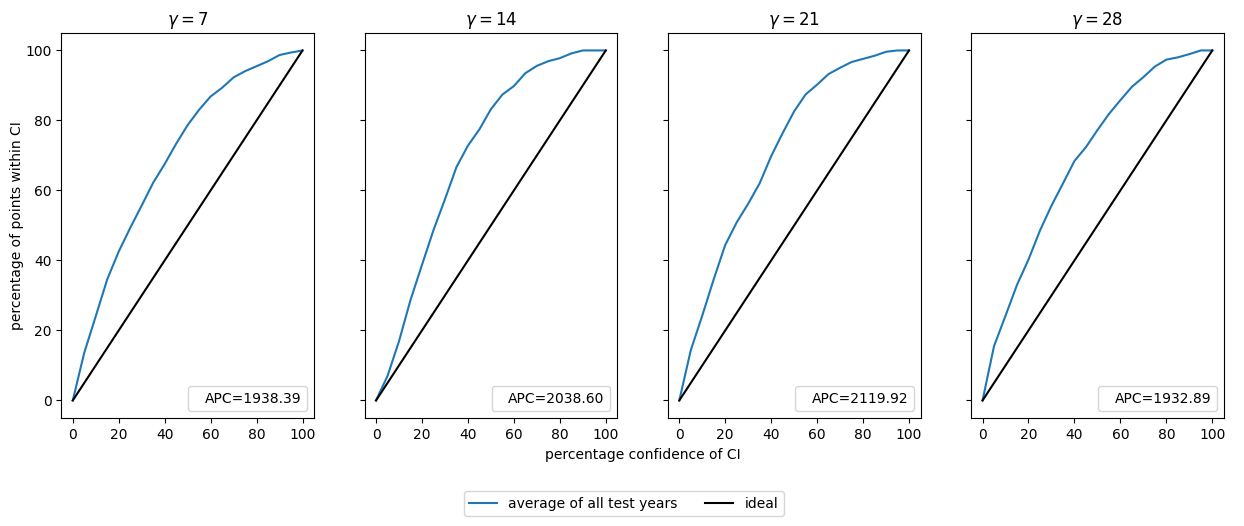

In [4]:
fig, axs = plt.subplots(1, len(models), figsize=(15, 5), sharey=True)
idx = 0
for gamma, calibration in calibrations.items():

    all_seasons = []
    for in_range in calibration.values():
        all_seasons.append(in_range)
    all_seasons = np.array(all_seasons)
    percentages = all_seasons.mean(axis=0).flatten()
    axs[idx].plot(confidences, percentages)

    axs[idx].plot([0,100], [0,100], label="APC={:.2f}".format(get_confidence_area(percentages)), c="black")
    axs[idx].set_title('$\gamma = {}$'.format(gamma))
    axs[idx].legend(handlelength=0, loc='lower right')
    idx += 1

save_multiplot_graph(fig, 'percentage confidence of CI', 'percentage of points within CI', figures_dir, 'test.png', labels=['average of all test years', 'ideal'])

In [5]:
# graphs on
test_year = 2015
test_gamma = 28
test_gamma_str = str(test_gamma)
test_year_str = str(test_year)

In [6]:
# UNNORMALISING
test_years = ['2015','2016','2017','2018']
for year in test_years:
    for gamma in gammas:
        _data = DataConstructor(gamma=gamma, test_season=int(year))
        _, _, _, y_test = _data(data_type, filename=filename)
        y_test = y_test._numpy()
        for i in range(gamma):
            y_hat = predictions[str(gamma)][year][Y_HAT][:,i,:].flatten()
            predictions[str(gamma)][year][Y_HAT][:,i,:] = rescale_array('y', y_hat, _data.scaler)
            predictions[str(gamma)][year][SD_HAT][:,i,:] = rescale_array('unc', predictions[str(gamma)][year][SD_HAT][:,i,:].flatten(), _data.scaler, y=y_hat)
            predictions[str(gamma)][year][DATA_UNC][:,i,:] = rescale_array('unc', predictions[str(gamma)][year][DATA_UNC][:,i,:].flatten(), _data.scaler, y=y_hat)
            predictions[str(gamma)][year][MODEL_UNC][:,i,:] = rescale_array('unc', predictions[str(gamma)][year][MODEL_UNC][:,i,:].flatten(), _data.scaler, y=y_hat)

(218, 7, 1)
(218, 14, 1)
(218, 21, 1)
(218, 28, 1)


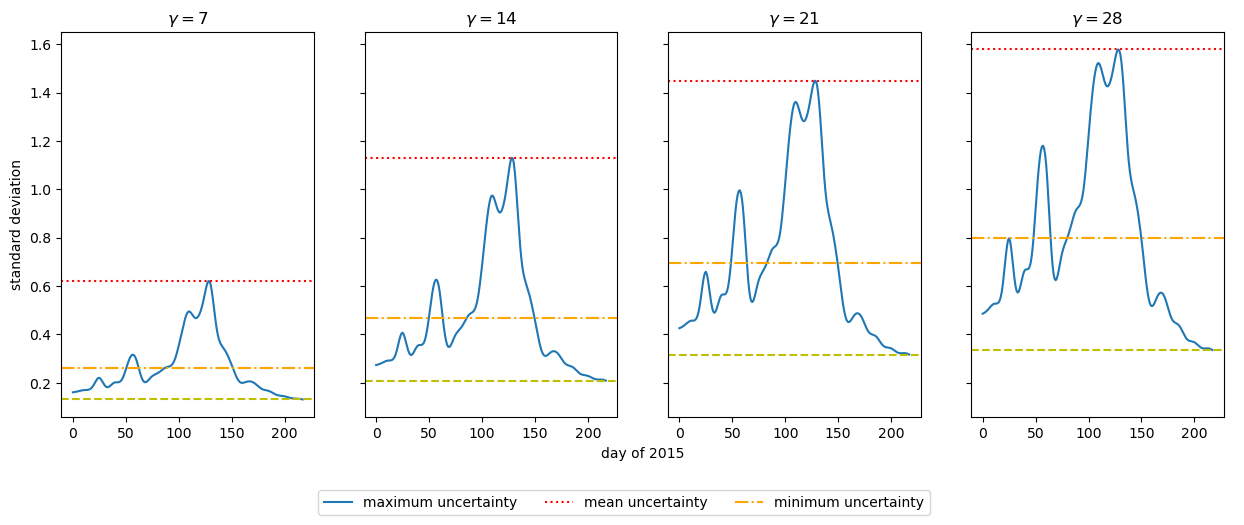

In [ ]:
fig, axs = plt.subplots(1, len(models), figsize=(15, 5), sharey=True)
idx = 0
days = np.arange(0,365)
for gamma, prediction in predictions.items():

    print(prediction[test_year_str][SD_HAT].shape)

    sds = prediction[test_year_str][SD_HAT][:,-1:,:].flatten()
    axs[idx].plot(sds, label='$\gamma = {}$'.format(gamma))
    axs[idx].axhline(y = np.max(sds), color = 'r', linestyle = ':', label='maximum uncertainty')
    axs[idx].axhline(y = np.mean(sds), color = 'orange', linestyle = '-.', label='mean uncertainty')
    axs[idx].axhline(y = np.min(sds), color = 'y', linestyle = '--', label='minimum uncertainty')
    axs[idx].set_title('$\gamma = {}$'.format(gamma))
    idx += 1

save_multiplot_graph(fig, 'day of {}'.format(test_year_str), 'standard deviation', figures_dir, 'test.png', ['maximum uncertainty', 'mean uncertainty', 'minimum uncertainty'])

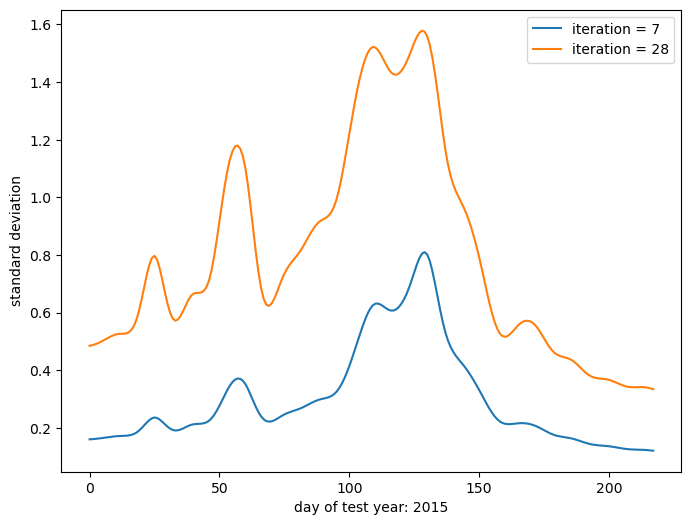

In [ ]:
fig = plt.figure()
iterations = [2,7]
# iterations = [1,7,14,28]
iterations = [7,test_gamma]
# iterations = [7,14,21,28,49,56,63,70]
for iteration in range(test_gamma):
    if iteration+1 in iterations:
        plt.plot(predictions[test_gamma_str][test_year_str][SD_HAT][:,iteration,:].flatten(), label='iteration = {}'.format(iteration+1))

# plt.xlim([max(iterations), 365])

save_xy_graph(fig, 'day of test year: {}'.format(test_year_str), 'standard deviation', figures_dir, 'test.png')

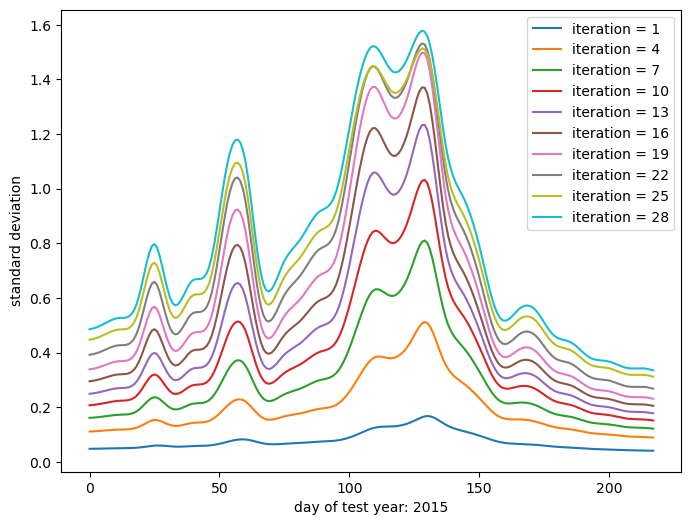

In [ ]:
fig = plt.figure()
iterations = [2,7]
# iterations = [1,7,14,28]
iterations = [7,test_gamma]
iterations = [1,4,7,10,13,16,19,22,25,test_gamma]
# iterations = [7,14,21,28,49,56,63,70]
for iteration in range(test_gamma):
    if iteration+1 in iterations:
        plt.plot(predictions[test_gamma_str][test_year_str][SD_HAT][:,iteration,:].flatten(), label='iteration = {}'.format(iteration+1))

# plt.xlim([max(iterations), 365])

save_xy_graph(fig, 'day of test year: {}'.format(test_year_str), 'standard deviation', figures_dir, 'test.png')

190 190 190 190


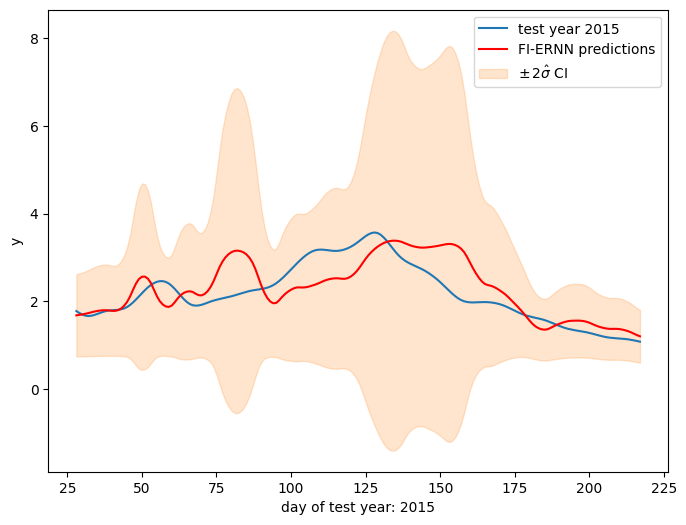

In [ ]:
# plot predictions and CIs
y_hat = predictions[test_gamma_str][test_year_str][Y_HAT][:,-1,:].flatten()[:len(y_test)-test_gamma]
sd_hat = predictions[test_gamma_str][test_year_str][SD_HAT][:,-1,:].flatten()[:len(y_test)-test_gamma]
_data = DataConstructor(gamma=test_gamma, test_season=test_year)
_, _, _, y_test = _data(data_type, filename=filename)
y_test = y_test._numpy()
y_test = rescale_array('y', y_test[:,test_gamma-1,:].flatten(), _data.scaler)
days = np.arange(test_gamma,len(y_test))
print(len(y_test)-test_gamma, len(days), len(y_hat), len(sd_hat))
while len(y_hat) != len(days) and len(sd_hat) != len(days):
    print(len(y_test)-test_gamma, len(days), len(y_hat), len(sd_hat))
    y_hat = predictions[test_gamma_str][test_year_str][Y_HAT][:,-1,:].flatten()[:len(y_test)-test_gamma]
    sd_hat = predictions[test_gamma_str][test_year_str][SD_HAT][:,-1,:].flatten()[:len(y_test)-test_gamma]

fig = plt.figure()
plt.plot(days, y_test.flatten()[:len(y_test)-test_gamma], label='test year {}'.format(test_year_str))
plt.plot(days, y_hat, c='r', label='FI-ERNN predictions')
ci_lower = y_hat - 2 * sd_hat
ci_upper = y_hat + 2 * sd_hat
plt.fill_between(np.squeeze(days), np.squeeze(ci_lower), np.squeeze(ci_upper), alpha=.2, label='$\pm\,2\hat\sigma$ CI', color='C1')
save_xy_graph(fig, 'day of test year: {}'.format(test_year_str), 'y', figures_dir, 'test.png')

In [ ]:
from sklearn import metrics
import properscoring as ps
from scipy.stats import pearsonr

def nll_metric(true, pred, sd):
    return (-tfp.distributions.Normal(pred, sd).log_prob(true)).numpy().mean()

def skill_metric(true, pred, sd):
    dist = tfp.distributions.Normal(loc=pred, scale=sd)
    mbl = np.log((dist.cdf(true + 0.6) - dist.cdf(true - 0.5)).numpy())
    mbl[np.invert(np.isfinite(mbl))] = -10
    mbl[mbl<-10] = -10

    return np.exp(mbl.mean())

length_scoring = 365-test_gamma
nll_score = 0
mae_score = 0
mse_score = 0
crps_score = 0
skill_score = 0
r_score = 0
for year in test_years:
    _data = DataConstructor(gamma=test_gamma, test_season=int(year))
    _, _, _, y_test = _data(data_type, filename=filename)
    y_test = y_test._numpy()
    y_test = rescale_array('y', y_test[:,test_gamma-1,:].flatten(), _data.scaler)
    length_scoring = len(y_test)-test_gamma
    y_test = y_test.flatten()[:length_scoring]

    y_hat = predictions[test_gamma_str][year][Y_HAT][:,-1,:].flatten()[:length_scoring]
    sd_hat = predictions[test_gamma_str][year][SD_HAT][:,-1,:].flatten()[:length_scoring]

    nll_score += nll_metric(y_test, y_hat, sd_hat)
    mae_score += metrics.mean_absolute_error(y_test, y_hat)
    mse_score += metrics.mean_squared_error(y_test, y_hat)
    crps_score += ps.crps_gaussian(y_test, y_hat, sd_hat).mean()
    skill_score += skill_metric(y_test, y_hat, sd_hat)
    r_score += pearsonr(y_test, y_hat)[0]

nll_score /= len(test_years)
mae_score /= len(test_years)
mse_score /= len(test_years)
crps_score /= len(test_years)
skill_score /= len(test_years)
r_score /= len(test_years)

print('"NLL": ', nll_score, ',')
print('"MAE": ', mae_score, ',')
print('"MSE":', mse_score, ',')
print('"CRPS": ', crps_score, ',')
print('"Skill": ', skill_score, ',')
print('"r": ', r_score)


"NLL":  1.107277736067772 ,
"MAE":  0.6515117436647415 ,
"MSE": 1.1804513037204742 ,
"CRPS":  0.5092011094093323 ,
"Skill":  0.33410999178886414 ,
"r":  0.8360632773524822
